In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import gc

In [2]:
def get_cat(inp):
    tokens = inp.split("_")
    return tokens[0]

def get_dept(inp):
    tokens = inp.split("_")
    return tokens[0] + "_" + tokens[1]

In [3]:
pd.set_option('display.max_columns', None)

### Building all the aggregation levels

In [4]:
l12 = pd.read_csv("m5-forecasting/sales_train_evaluation.csv")
l12.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  d_5  d_6  d_7  d_8  d_9  d_10  d_11  d_12  \
0       CA    0    0    0    0    0    0    0    0    0     0     0     0   
1       CA    0    0    0    0    0    0    0    0    0     0     0     0   
2       CA    0    0    0    0    0    0    0    0    0     0     0     0   
3       CA    0    0    0    0    0    0    0    0    0     0     0     0   
4       CA    0    0    0    0    0    0    0    0    0     0     0     0   

   d_13  d_14  d_15  d_16  d_17  d_18  d_19  d_20  d_21  d_22  d_23  d_24  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     0     0     0     0     0     0     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_25  d_26  d_27  d_28  d_29  d_30  d_31  d_32  d_33  d_34  d_35  d_36  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     0     0     0     0     0     0     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_37  d_38  d_39  d_40  d_41  d_42  d_43  d_44  d_45  d_46  d_47  d_48  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     2     0     0     0     2     0     1     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_49  d_50  d_51  d_52  d_53  d_54  d_55  d_56  d_57  d_58  d_59  d_60  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     2     0     1     0     0     1     1     1     0     2     3   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_61  d_62  d_63  d_64  d_65  d_66  d_67  d_68  d_69  d_70  d_71  d_72  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     1     0     0     0     0     0     1     0     0     1     1     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_73  d_74  d_75  d_76  d_77  d_78  d_79  d_80  d_81  d_82  d_83  d_84  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     1     0     0     1     2     3     0     2     0     0     2   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_85  d_86  d_87  d_88  d_89  d_90  d_91  d_92  d_93  d_94  d_95  d_96  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   


In [5]:
l12.id = l12.id.str.replace('_evaluation', '')  # 将id中的_evaluation部分删除
l12.head()

id        item_id    dept_id   cat_id store_id state_id  \
0  HOBBIES_1_001_CA_1  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1       CA   
1  HOBBIES_1_002_CA_1  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1       CA   
2  HOBBIES_1_003_CA_1  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1       CA   
3  HOBBIES_1_004_CA_1  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1       CA   
4  HOBBIES_1_005_CA_1  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1       CA   

   d_1  d_2  d_3  d_4  d_5  d_6  d_7  d_8  d_9  d_10  d_11  d_12  d_13  d_14  \
0    0    0    0    0    0    0    0    0    0     0     0     0     0     0   
1    0    0    0    0    0    0    0    0    0     0     0     0     0     0   
2    0    0    0    0    0    0    0    0    0     0     0     0     0     0   
3    0    0    0    0    0    0    0    0    0     0     0     0     0     0   
4    0    0    0    0    0    0    0    0    0     0     0     0     0     0   

   d_15  d_16  d_17  d_18  d_19  d_20  d_21  d_22  d_23  d_24  d_25  d_26  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     0     0     0     0     0     0     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_27  d_28  d_29  d_30  d_31  d_32  d_33  d_34  d_35  d_36  d_37  d_38  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     0     0     0     0     0     0     0     0     0     2     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_39  d_40  d_41  d_42  d_43  d_44  d_45  d_46  d_47  d_48  d_49  d_50  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     0     2     0     1     0     0     0     0     0     0     2   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_51  d_52  d_53  d_54  d_55  d_56  d_57  d_58  d_59  d_60  d_61  d_62  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     1     0     0     1     1     1     0     2     3     1     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_63  d_64  d_65  d_66  d_67  d_68  d_69  d_70  d_71  d_72  d_73  d_74  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     0     0     0     1     0     0     1     1     0     0     1   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_75  d_76  d_77  d_78  d_79  d_80  d_81  d_82  d_83  d_84  d_85  d_86  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     0     1     2     3     0     2     0     0     2     2     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_87  d_88  d_89  d_90  d_91  d_92  d_93  d_94  d_95  d_96  d_97  d_98  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     

In [6]:
COLS = [f"d_{i+1}" for i in range(1941)]  # 将字段名d_1至d_1941储存在COLS列表中
COLS

['d_1',
 'd_2',
 'd_3',
 'd_4',
 'd_5',
 'd_6',
 'd_7',
 'd_8',
 'd_9',
 'd_10',
 'd_11',
 'd_12',
 'd_13',
 'd_14',
 'd_15',
 'd_16',
 'd_17',
 'd_18',
 'd_19',
 'd_20',
 'd_21',
 'd_22',
 'd_23',
 'd_24',
 'd_25',
 'd_26',
 'd_27',
 'd_28',
 'd_29',
 'd_30',
 'd_31',
 'd_32',
 'd_33',
 'd_34',
 'd_35',
 'd_36',
 'd_37',
 'd_38',
 'd_39',
 'd_40',
 'd_41',
 'd_42',
 'd_43',
 'd_44',
 'd_45',
 'd_46',
 'd_47',
 'd_48',
 'd_49',
 'd_50',
 'd_51',
 'd_52',
 'd_53',
 'd_54',
 'd_55',
 'd_56',
 'd_57',
 'd_58',
 'd_59',
 'd_60',
 'd_61',
 'd_62',
 'd_63',
 'd_64',
 'd_65',
 'd_66',
 'd_67',
 'd_68',
 'd_69',
 'd_70',
 'd_71',
 'd_72',
 'd_73',
 'd_74',
 'd_75',
 'd_76',
 'd_77',
 'd_78',
 'd_79',
 'd_80',
 'd_81',
 'd_82',
 'd_83',
 'd_84',
 'd_85',
 'd_86',
 'd_87',
 'd_88',
 'd_89',
 'd_90',
 'd_91',
 'd_92',
 'd_93',
 'd_94',
 'd_95',
 'd_96',
 'd_97',
 'd_98',
 'd_99',
 'd_100',
 'd_101',
 'd_102',
 'd_103',
 'd_104',
 'd_105',
 'd_106',
 'd_107',
 'd_108',
 'd_109',
 'd_110',
 'd_111'

In [7]:
%%time
print("State & Item")  
l11 = l12.groupby(['state_id','item_id']).sum().reset_index()
l11["store_id"] = l11["state_id"]
l11["cat_id"] = l11["item_id"].apply(get_cat)
l11["dept_id"] = l11["item_id"].apply(get_dept)
l11["id"] = l11["state_id"] + "_" + l11["item_id"]
print("Item")
l10 = l12.groupby('item_id').sum().reset_index()
l10['id'] = l10['item_id'] + '_X'
l10["cat_id"] = l10["item_id"].apply(get_cat)
l10["dept_id"] = l10["item_id"].apply(get_dept)
l10["store_id"] = 'X'
l10["state_id"] = 'X'
print("Store & Dept")
l9 = l12.groupby(['store_id','dept_id']).sum().reset_index()
l9["cat_id"] = l9["dept_id"].apply(get_cat)
l9["state_id"] = l9["store_id"].apply(get_cat)
l9["item_id"] = l9["dept_id"]
l9["id"] = l9["store_id"] + '_' + l9["dept_id"]
print("Store & Cat")
l8 = l12.groupby(['store_id','cat_id']).sum().reset_index()
l8['dept_id'] = l8['cat_id']
l8['item_id'] = l8['cat_id']
l8['state_id'] = l8['store_id'].apply(get_cat)
l8["id"] = l8["store_id"] + '_' + l8["cat_id"]
print("State & Dept")
l7 = l12.groupby(['state_id','dept_id']).sum().reset_index()
l7["store_id"] = l7["state_id"]
l7["cat_id"] = l7["dept_id"].apply(get_cat)
l7["item_id"] = l7["dept_id"]
l7["id"] = l7["state_id"] + '_' + l7["dept_id"]
print("State & Cat")
l6 = l12.groupby(['state_id','cat_id']).sum().reset_index()
l6["store_id"] = l6["state_id"]
l6["dept_id"] = l6["cat_id"]
l6["item_id"] = l6["cat_id"]
l6["id"] = l6["state_id"] + "_" + l6["cat_id"]
print("Dept")
l5 = l12.groupby('dept_id').sum().reset_index()
l5["cat_id"] = l5["dept_id"].apply(get_cat)
l5["item_id"] = l5["dept_id"]
l5["state_id"] = "X"
l5["store_id"] = "X"
l5["id"] = l5["dept_id"] + "_X"
print("Cat")
l4 = l12.groupby('cat_id').sum().reset_index()
l4["store_id"] = l4["cat_id"]
l4["item_id"] = l4["cat_id"]
l4["store_id"] = "X"
l4["state_id"] = "X"
l4["id"] = l4["cat_id"] + "_X"
print("Store")
l3 = l12.groupby('store_id').sum().reset_index()
l3["state_id"] = l3["store_id"].apply(get_cat)
l3["cat_id"] = "X"
l3["dept_id"] = "X"
l3["item_id"] = "X"
l3["id"] = l3["store_id"] + "_X"
print("State")
l2 = l12.groupby('state_id').sum().reset_index()
l2["store_id"] = l2["state_id"]
l2["cat_id"] = "X"
l2["dept_id"] = "X"
l2["item_id"] = "X"
l2["id"] = l2["state_id"] + "_X"
print("Total")
l1 = l12[COLS].sum(axis=0).values
l1 = pd.DataFrame(l1).T
l1.columns = COLS
l1["id"] = 'Total_X'
l1['state_id'] = 'X'
l1['store_id'] = 'X'
l1['cat_id'] = 'X'
l1['dept_id'] = 'X'
l1['item_id'] = 'X'

State & Item
Item
Store & Dept
Store & Cat
State & Dept
State & Cat
Dept
Cat
Store
State
Total
CPU times: user 10.4 s, sys: 4.4 s, total: 14.8 s
Wall time: 15.9 s


In [8]:
df = pd.DataFrame()
df = df.append([l12, l11, l10, l9, l8, l7, l6, l5, l4, l3, l2, l1])

In [9]:
sub = pd.read_csv("m5-forecasting/sample_submission.csv")
sub['id'] = sub.id.str.replace('_evaluation', '')
grps =sub.iloc[-42840:, 0].unique()
grps = [col.replace("_0.995","") for col in grps]

In [10]:
for col in ['id','item_id','dept_id','cat_id','store_id','state_id']:
    print(col, df[col].nunique())

id 42840
item_id 3060
dept_id 11
cat_id 4
store_id 14
state_id 4


## Computing scale and start date

In [11]:
X = df[COLS].values
x = (X>0).cumsum(1)
x = x>0
st = x.argmax(1)
den = 1941 - st - 2
diff = np.abs(X[:,1:] - X[:,:-1])
norm = diff.sum(1) / den

In [12]:
df["start"] = st
df["scale"] = norm

In [14]:
df.tail(5)

id item_id dept_id cat_id store_id state_id    d_1    d_2    d_3  \
9   WI_3_X       X       X      X     WI_3       WI   4038   4198   3317   
0     CA_X       X       X      X       CA       CA  14195  13805  10108   
1     TX_X       X       X      X       TX       TX   9438   9630   6778   
2     WI_X       X       X      X       WI       WI   8998   8314   6897   
0  Total_X       X       X      X        X        X  32631  31749  23783   

     d_4    d_5    d_6    d_7    d_8    d_9   d_10   d_11   d_12   d_13  \
9   3211   2132   4590   4486   5991   4850   3240   3053   3312   3309   
0  11047   9925  11322  12251  16610  14696  11822  10933  10350  11204   
1   7381   5912   9006   6226   9440   9376   7319   6224   6740   6109   
2   6984   3309   8883   9533  11882   8664   6431   5914   6568   6443   
0  25412  19146  29211  28010  37932  32736  25572  23071  23658  23756   

    d_14   d_15   d_16   d_17   d_18   d_19   d_20   d_21   d_22   d_23  \
9   3928   5066   4677   2907   3771   3065   2934   3300   4059   3022   
0  11354  14610  15630   9044   9496   8844   7835  10025  13870  13465   
1   7202  10081  11725   6719   7460   6606   6412   6711   9150   9789   
2   7889  10142   9025   6041   7114   5993   6071   6985   8669   6029   
0  26445  34833  36380  21804  24070  21443  20318  23721  31689  29283   

    d_24   d_25   d_26   d_27   d_28   d_29   d_30   d_31   d_32   d_33  \
9   2377   2324   2870   2568   3034   3555   3703   2625   2989   3350   
0  11997   9130   8941   8514   9847  13652  12491   9196   9782   9537   
1   7297   6628   5814   6175   6286   8586   9086   6555   7082   6145   
2   4672   4743   6002   5588   6396   7670   7130   5489   6008   6364   
0  23966  20501  20757  20277  22529  29908  28707  21240  22872  22046   

    d_34   d_35   d_36   d_37   d_38   d_39   d_40   d_41   d_42   d_43  \
9   3842   3325   4346   4506   2898   3068   3031   3240   3584   4413   
0   9710  10444  13784  16057  10953  10299   9951  10012  11189  13710   
1   6639   6584   9238  10423   7623   6335   6941   6339   7203   9271   
2   7126   6544   8180   8396   5986   6118   5668   6275   7180   9244   
0  23475  23572  31202  34876  24562  22752  22560  22626  25572  32225   

    d_44   d_45   d_46   d_47   d_48   d_49   d_50   d_51   d_52   d_53  \
9   3753   3323   3552   3065   2621   3145   3706   3467   2849   2236   
0  14340  10722   9293   9752   9504  10030  14509  14112  10255   9383   
1   9542   7745   7834   6768   6759   7131   8203   8992   7075   6086   
2   7535   6468   6894   6245   5516   6694   7887   6539   5771   5023   
0  31417  24935  24021  22765  21779  23855  30599  29643  23101  20492   

    d_54   d_55   d_56   d_57   d_58   d_59   d_60   d_61   d_62   d_63  \
9   2230   2334   2847   3629   3376   2459   2540   1821   2322   3471   
0   8490   7889  11011  13816  13661   9997   8516   8911  10059  12827   
1   5914   5898   6249   8072   9434   6429   5728   5384   6096   7992   
2   4826   5067   6090   7732   6771   5023   5337   4633   5587   7490   
0  19230  18854  23350  29620  29866  21449  19581  18928  21742  28309   

    d_64   d_65   d_66   d_67   d_68   d_69   d_70   d_71   d_72   d_73  \
9   4609   4163   2933   3135   2961   2432   3445   4226   3497   3106   
0  14791  15341  12356  10497  10101  10575  10971  14064  15291  11098   
1   9134   9863   6648   6743   6689   7201   6797   9025   9648   7555   
2   9553   7854   5848   6341   5866   5125   6986   8656   6597   6176   
0  33478  33058  24852  23581  22656  22901  24754  31745  31536  24829   

    d_74   d_75   d_76   d_77   d_78   d_79   d_80   d_81   d_82   d_83  \
9   3352   2675   3011   3604   3793   3535   2728   2093   2586   2407   
0   9181   8853   9430  10922  12809  13894   9955   8930   8582   8986   
1   7302   7202   6338   7749   8573   9248   7218   6133   6387   5677   
2   6735   5556   6196   6811   7852   6645   5216   4411   5219   5105   
0  23218  21611  21

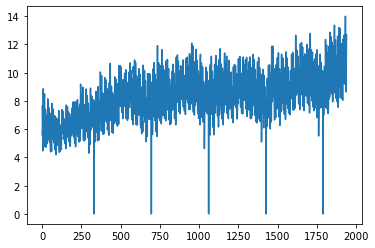

In [16]:
plt.plot(X[-1]/norm[-1])
plt.show()

In [17]:
df.to_csv("sales_add.csv", index=False)

In [18]:
df.shape

(42840, 1949)